# Neural Flow Diffusion Models from Scratch

## Imports and utilities

In [2]:
from abc import ABC, abstractmethod
from typing import Callable

import numpy as np

import torch
from torch import nn, Tensor

import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [3]:
class Net(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, out_dim),
        )
        
    def forward(self, t: Tensor) -> Tensor:
        return self.net(t)

In [4]:
@torch.no_grad()
def solve_sde(
        sde: Callable[[Tensor, Tensor], tuple[Tensor, Tensor]],
        z: Tensor,
        ts: float,
        tf: float,
        n_steps: int,
        show_pbar: bool=False
):
    bs = z.shape[0]

    t_steps = torch.linspace(ts, tf, n_steps + 1)
    dt = (tf - ts) / n_steps
    dt_2 = abs(dt) ** 0.5

    path = [z]
    pbar = tqdm if show_pbar else (lambda a: a)
    for t in pbar(t_steps[:-1]):
        t = t.expand(bs, 1)

        f, g = sde(z, t)

        w = torch.randn_like(z)
        z = z + f * dt + g * w * dt_2

        path.append(z)

    return z, (t_steps, torch.stack(path))


def solve_ode(
        ode: Callable[[Tensor, Tensor], Tensor],
        z: Tensor,
        ts: float,
        tf: float,
        n_steps: int,
        show_pbar: bool=False
):
    def sde(z_in: Tensor, t_in: Tensor) -> tuple[Tensor, Tensor]:
        return ode(z_in, t_in), torch.zeros_like(z_in)

    return solve_sde(sde, z, ts, tf, n_steps, show_pbar)

In [5]:
def viz_1d_path(t_steps: Tensor, path: Tensor, color: str | None=None):
    plt.plot(t_steps, path, color=color, alpha=0.5)
    plt.show()

In [6]:
def viz_2d_data(data: Tensor):
    plt.scatter(data[:, 0], data[:, 1], s=1)
    plt.axis("scaled")
    plt.show()

In [7]:
def viz_2d_path(t_steps: Tensor, path: Tensor, n_lines: int=-1, color: str | None=None):
    plt.figure(figsize=(12, 12))
    plt.scatter(15 + path[0, :, 0], path[0, :, 1], s=1)
    plt.scatter(path[-1, :, 0], path[-1, :, 1], s=1)
    plt.plot(15 * t_steps[:, None] + path[:, :n_lines, 0],
             path[:, :n_lines, 1],
             color=color, alpha=0.5)
    plt.axis("scaled")
    plt.tick_params(left=False, labelleft=False,
                    bottom=False, labelbottom=False)
    plt.show()

In [8]:
def gen_data(n: int):
    scale = 4.
    centers = torch.tensor([
        [1, 0],
        [-1, 0],
        [0, 1],
        [0, -1],
        [1. / np.sqrt(2), 1. / np.sqrt(2)],
        [1. / np.sqrt(2), -1. / np.sqrt(2)],
        [-1. / np.sqrt(2), 1. / np.sqrt(2)],
        [-1. / np.sqrt(2), -1. / np.sqrt(2)]
    ], dtype=torch.float32)
    centers = scale * centers

    x = torch.randn(n, 2)
    x = 0.5 * x

    center_ids = torch.randint(0, 8, (n,))
    x = x + centers[center_ids]

    x = x / 2 ** 0.5

    return x

## Forward Process

Here, we define the forward process through the reparameterization function $F_\varphi(\varepsilon, t, \mathbf{x})$. Although the NFDM framework allows for more general parameterizations, for simplicity, we use a Gaussian parameterization of $F_\varphi$ in this notebook:

\begin{align}
    \mathbf{z}_t = F_\varphi(\varepsilon, t, \mathbf{x}) = \mu_\varphi(\mathbf{x}, t) + \sigma_\varphi(\mathbf{x}, t) \varepsilon.
\end{align}

As a special case, we can parameterize it as a conditional optimal transport (FM-OT) flow:

\begin{align}
    \mathbf{z}_t = F(\varepsilon, t, \mathbf{x}) = \underbrace{(1 - t) \mathbf{x}}_{\mu(\mathbf{x}, t)} + \underbrace{(t + (1 - t) * 0.01)}_{\sigma(\mathbf{x}, t)} \varepsilon.
\end{align}

However, we will use a learnable Gaussian forward process (NFDM-Gaussian) in this notebook, where $\mu_\varphi$ and $\sigma_\varphi$ are parameterised by a neural network.

In [9]:
class AffineFlow(nn.Module, ABC):
    @abstractmethod
    def forward(self, x: Tensor, t: Tensor) -> tuple[Tensor, Tensor]:
        raise NotImplementedError


class AffineOT(AffineFlow):
    def forward(self, x: Tensor, t: Tensor) -> tuple[Tensor, Tensor]:
        return (1 - t) * x, t + (1 - t) * 0.01


class AffineNeural(AffineFlow):
    def __init__(self, d: int):
        super().__init__()

        self.net = Net(d + 1, 2 * d)

    def forward(self, x: Tensor, t: Tensor) -> tuple[Tensor, Tensor]:
        x_t = torch.cat([x, t], dim=1)
        m_ls = self.net(x_t)
        m, ls = m_ls.chunk(2, dim=1)

        m = (1 - t) * x + t * (1 - t) * m
        ls = (1 - t) * np.log(0.01) + t * (1 - t) * ls

        return m, torch.exp(ls)

After defining $F_\varphi$, we can compute its corresponding conditional Ordinary Differential Equation (ODE), $f_\varphi(\mathbf{z}, t, \mathbf{x})$, as well as the conditional score function $\nabla_\mathbf{z_t} \log q_\varphi(\mathbf{z}_t, \mathbf{x})$, which is used in the conditional Stochastic Differential Equation (SDE).

\begin{align}
    \frac{d}{dt} f_\varphi(\mathbf{z}_t, t, \mathbf{x})
    &= \left. \frac{\partial F_\varphi(\varepsilon, t, \mathbf{x})}{\partial t} \right|_{\varepsilon=F_\varphi^{-1}(\mathbf{z}_t, t, \mathbf{x})} \\
    &= \left. \frac{\partial \mu_\varphi(\mathbf{x}, t)}{\partial t} + \frac{\partial \sigma_\varphi(\mathbf{x}, t)}{\partial t} \varepsilon \right|_{\varepsilon=F_\varphi^{-1}(\mathbf{z}_t, t, \mathbf{x})} \\
    &= \frac{\partial \mu_\varphi(\mathbf{x}, t)}{\partial t} + \frac{\partial \sigma_\varphi(\mathbf{x}, t)}{\partial t} \frac{\mathbf{z} - \mu_\varphi(\mathbf{x}, t)}{\sigma_\varphi(\mathbf{x}, t)}
\end{align}

\begin{align}
    \nabla_\mathbf{z_t} \log q_\varphi(\mathbf{z}_t, \mathbf{x})
    &= \left. - \frac{\varepsilon}{\sigma_\varphi(\mathbf{x}, t)} \right|_{\varepsilon=F_\varphi^{-1}(\mathbf{z}_t, t, \mathbf{x})} \\
    &= \frac{\mu_\varphi(\mathbf{x}, t) - \mathbf{z}}{\sigma^2_\varphi(\mathbf{x}, t)}
\end{align}



In [10]:
def jvp(f: Callable[[Tensor], ...], x: Tensor, v: Tensor) -> tuple[Tensor, ...]:
    return torch.autograd.functional.jvp(
        f, x, v, 
        create_graph=torch.is_grad_enabled()
    )


def t_dir(f: Callable[[Tensor], ...], t: Tensor) -> tuple[Tensor, ...]:
    return jvp(f, t, torch.ones_like(t))

In [11]:
class AffineTransform(nn.Module):
    def __init__(self, flow: AffineFlow):
        super().__init__()

        self.flow = flow

    def get_t_dir(self, x: Tensor, t: Tensor) -> tuple[tuple[Tensor, Tensor], tuple[Tensor, Tensor]]:
        def f(x_in):
            def f_(t_in):
                return self.flow(x_in, t_in)
            return f_

        return t_dir(f(x), t)

    def forward(self, eps: Tensor, t: Tensor, x: Tensor) -> tuple[Tensor, Tensor, Tensor]:
        (m, s), (dm, ds) = self.get_t_dir(x, t)

        z = m + s * eps
        dz = dm + ds * eps
        score = - eps / s

        return z, dz, score

    def inverse(self, z: Tensor, t: Tensor, x: Tensor) -> tuple[Tensor, Tensor, Tensor]:
        (m, s), (dm, ds) = self.get_t_dir(x, t)

        eps = (z - m) / s
        dz = dm + ds / s * (z - m)
        score = (m - z) / s ** 2

        return eps, dz, score

As a simple example, we can visualize the path of the forward process in 1D. Importantly, in this example, the forward process is not trained. Nevertheless, thanks to the parameterization, we can observe that the trajectories start near $\mathbf{x}=-1$ and end at their corresponding $\varepsilon$ values.

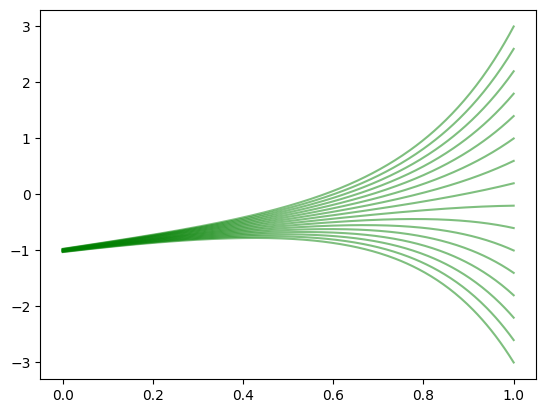

In [12]:
bs = 16

x = -torch.ones(bs, 1)
z = torch.linspace(-3, 3, bs)[:, None]

flow = AffineNeural(d=1)
transform = AffineTransform(flow=flow)


def cond_ode(z_in, t_in):
    _, dz, _ = transform.inverse(z_in, t_in, x)
    return dz


_, (t_steps, path) = solve_ode(ode=cond_ode, z=z, ts=1, tf=0, n_steps=300)

viz_1d_path(t_steps, path[:, :, 0], color="green")

Next, we introduce the volatility function $g_\varphi(t)$, which parameterizes the volatility of the conditional SDE. Similar to the function $F_\varphi$, the volatility can be either fixed or parameterized by a neural network.

With access to the conditional ODE, the conditional score function, and the volatility, we can compute the drift term of the conditional SDE:

\begin{align}
    d \mathbf{z}_t &= \tilde{f}_\varphi(\mathbf{z}_t, t, \mathbf{x}) d t + g_\varphi(t) d \bar{w}, \quad \textrm{where} \\
    \tilde{f}_\varphi(\mathbf{z}_t, t, \mathbf{x}) &= f_\varphi(\mathbf{z}_t, t, \mathbf{x}) - \frac{g_\varphi^2(t)}{2} \nabla_\mathbf{z_t} \log q(\mathbf{z}_t, \mathbf{x}).
\end{align}

In [13]:
class VolatilityLinSNR(nn.Module):
    def forward(self, t: Tensor) -> Tensor:
        return (20 * torch.sigmoid(-10 + 20 * t)) ** 0.5


class VolatilityNeural(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = Net(1, 1)
        self.sp = nn.Softplus()

    def forward(self, t: Tensor) -> Tensor:
        return self.sp(self.net(t))

In [14]:
def score_based_sde_drift(dz: Tensor, score: Tensor, g2: Tensor) -> Tensor:
    return dz - 0.5 * g2 * score

Similarly to the example with the conditional ODE, we can visualize the trajectories of the conditional SDE in 1D.

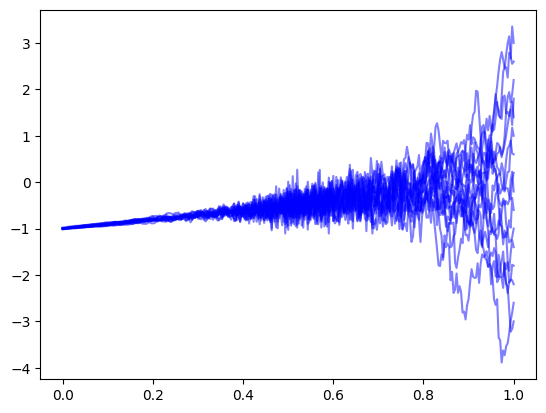

In [15]:
bs = 16

x = -torch.ones(bs, 1)
z = torch.linspace(-3, 3, bs)[:, None]

flow = AffineNeural(d=1)
transform = AffineTransform(flow=flow)
vol = VolatilityLinSNR()


def cond_sde(z_in, t_in):
    _, dz, score = transform.inverse(z_in, t_in, x)

    g = vol(t_in)
    g2 = g ** 2

    drift = score_based_sde_drift(dz, score, g2)

    return drift, g


_, (t_steps, path) = solve_sde(sde=cond_sde, z=z, ts=1, tf=0, n_steps=300)

viz_1d_path(t_steps, path[:, :, 0], color="blue")

## Reverse (Generative) Process

The reverse (or generative) process is defined by the marginal SDE:
\begin{align}
    d \mathbf{z}_t &= \tilde{f}_\theta(\mathbf{z}_t, t) d t + g_\varphi(t) d \bar{w}.
\end{align}

The parameterization of the drift term $\tilde{f}_\theta(\mathbf{z}t, t)$ is a design choice. In this notebook, we parameterize it by predicting $\hat{\mathbf{x}}_\theta(\mathbf{z}t, t)$ and then substituting it into the conditional SDE $\tilde{f}_\varphi(\mathbf{z}_t, t, \mathbf{x})$:

\begin{align}
    \tilde{f}_{\varphi, \theta}(\mathbf{z}_t, t) = \tilde{f}_\varphi \big( \mathbf{z}_t, t, \hat{\mathbf{x}}_\theta(\mathbf{z}_t, t) \big).
\end{align}

In [16]:
class Predictor(nn.Module):
    def __init__(self, d: int):
        super().__init__()

        self.net = Net(d + 1, d)

    def forward(self, z: Tensor, t: Tensor) -> Tensor:
        z_t = torch.cat([z, t], dim=1)
        x = self.net(z_t)

        x = (1 - t) * z + (t + 0.01) * x

        return x

## Neural Flow Diffusion Model

Finally, we can define the Neural Flow Diffusion Model (NFDM) that combines the forward and reverse processes. The loss function of the NFDM is the expectation of the squered norm of difference between the drift terms of the forward and reverse processes:

\begin{align}
    \mathcal{L}(\mathbf{x}, t) = \mathbb{E}_{u(t) q_\varphi(\mathbf{z}_t, \mathbf{x})} \left[ \frac{g_\varphi^2(t)}{2} \left\| \tilde{f}_\varphi(\mathbf{z}_t, t, \mathbf{x}) - \tilde{f}_{\varphi, \theta}(\mathbf{z}_t, t) \right\|_2^2 \right].
\end{align}

In [17]:
class NeuralDiffusion(nn.Module):
    def __init__(self, transform: AffineTransform, pred: Predictor, vol: nn.Module):
        super().__init__()

        self.transform = transform
        self.pred = pred
        self.vol = vol

    def forward(self, x: Tensor, t: Tensor):
        eps = torch.randn_like(x)

        z, f_dz, f_score = self.transform(eps, t, x)

        x_ = self.pred(z, t)
        _, r_dz, r_score = self.transform.inverse(z, t, x_)

        g2 = self.vol(t) ** 2
        f_drift = score_based_sde_drift(f_dz, f_score, g2)
        r_drift = score_based_sde_drift(r_dz, r_score, g2)

        loss = 0.5 * (f_drift - r_drift) ** 2 / g2
        loss = loss.sum(dim=1)

        return loss

## Training

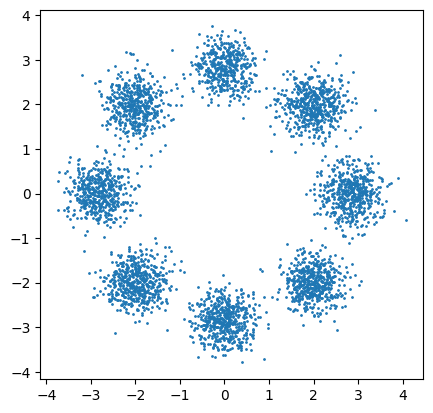

In [18]:
data_sample = gen_data(2 ** 12)

viz_2d_data(data_sample)

In [19]:
def train(model: NeuralDiffusion, gen_data_f: Callable[[int], Tensor]):
    iter = 10 ** 5
    bs = 2 ** 10

    optim = torch.optim.Adam(model.parameters(), lr=1e-3)

    pbar = trange(iter)
    for i in pbar:
        x = gen_data_f(bs)
        t = torch.rand(x.shape[0], 1)
        
        loss = model(x, t).mean()

        if (i + 1) % 100 == 0:
            pbar.set_description(f"{loss.item():.4f}")
        
        optim.zero_grad()
        loss.backward()
        optim.step()

In [19]:
transform = AffineTransform(flow=AffineNeural(d=2))
pred = Predictor(d=2)
vol = VolatilityNeural()
ndm = NeuralDiffusion(transform, pred, vol)

train(model=ndm, gen_data_f=gen_data)

10.5219: 100%|██████████| 100000/100000 [31:26<00:00, 53.02it/s]  


## Visualization of the learned diffusion process

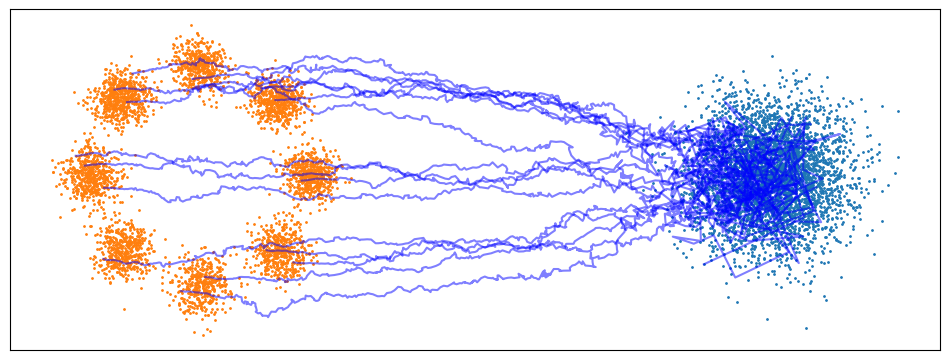

In [20]:
bs = 2 ** 12

z = torch.randn(bs, 2)


def sde(z_in, t_in):
    x_ = pred(z_in, t_in)

    _, dz, score = transform.inverse(z_in, t_in, x_)

    g = vol(t_in)
    g2 = g ** 2

    drift = score_based_sde_drift(dz, score, g2)

    return drift, g


_, (t_steps, path) = solve_sde(sde=sde, z=z, ts=1, tf=0, n_steps=300)

viz_2d_path(t_steps, path, n_lines=16, color="blue")

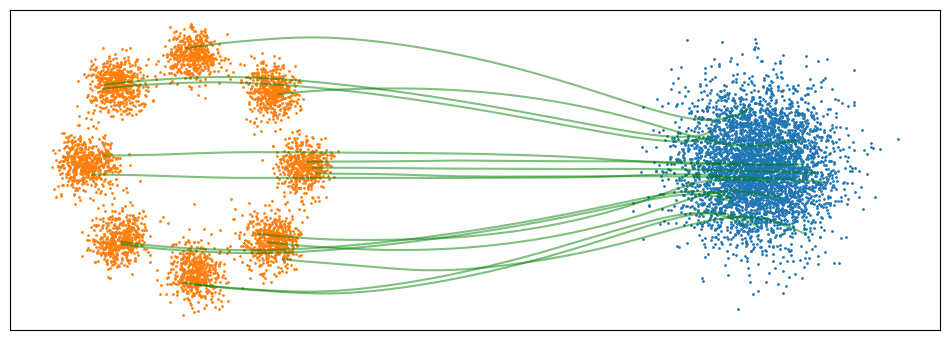

In [21]:
bs = 2 ** 12

z = torch.randn(bs, 2)


def ode(z_in, t_in):
    x_ = pred(z_in, t_in)
    _, dz, _ = transform.inverse(z_in, t_in, x_)
    return dz


_, (t_steps, path) = solve_ode(ode=ode, z=z, ts=1, tf=0, n_steps=300)

viz_2d_path(t_steps, path, n_lines=16, color="green")